In [348]:
import numpy as np
import pandas as pd
import seaborn as sns

# 1. Data Exploration

Before diving straight into anything, it is useful to look into the data

In [349]:
data_df = pd.read_csv("dataset.csv")
data_df.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11
0,0,a,-0.375866,0.427942,-0.922338,0.210758,0.109015,0.621001,-0.444421,0.089970,-0.707711,0.473700
1,0,b,0.047819,0.115627,-1.781739,-0.272785,0.392783,1.094168,-0.975254,-0.353424,0.145543,-0.064961
2,1,d,0.372868,-0.263291,-1.120545,-0.773828,0.830072,-1.727836,1.323876,-1.587291,-0.024916,0.082491
3,0,c,0.059598,0.270797,0.961795,-1.804197,2.931330,1.891656,0.094252,-0.873467,-1.217680,-1.848046
4,1,d,0.616319,0.291275,-1.113519,0.626864,-0.287989,-0.842649,-0.947257,1.198215,0.972420,-1.054313


In [350]:
n_samples = len(data_df)
n_features = len(data_df.columns) - 1
n_classes = len(set(data_df['y']))

print('Number of examples: {0}'.format(n_train))
print('Number of features: {0}'.format(n_features))
print('Number of classes: {0}'.format(n_classes))

Number of examples: 1700
Number of features: 11
Number of classes: 2


<AxesSubplot:xlabel='y', ylabel='count'>

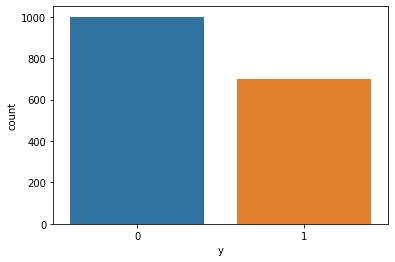

In [351]:
#Plot counts of each class
sns.countplot(x = 'y', data=data_df)

Some things to take note:

-The first feature is categorical. For simplicity sake, we will use a one-hot encoding where each category is represented with a binary vector 

-We don't have a testing dataset, so we will want to split our dataset into a training/validation/test set in which we use our training + validation set to train our model, and then we can evaluate the true performance of our final trained model on our untouched test set

-There is somewhat of a class imbalance, which can be an issue with binary classification problems. Can use stratified k fold cross validation to combat this. While data is being split into folds, each fold will have the same proportion of observations with a given categorical value. Some classification algorithms are extremely sensitive to class ratio they are trained on, so stratifying the data can help achieve more consistent prediction performance

# 2. Data pre-processing

In [352]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [353]:
#One hot encoding of x1 feature
one_hot_columns = pd.get_dummies(data_df.x1)
df_encoded = pd.concat([data_df, one_hot_columns], axis=1)
del df_encoded['x1']

In [354]:
df_encoded.head()

,y,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,a,b,c,d
0,0,-0.375866,0.427942,-0.922338,0.210758,0.109015,0.621001,-0.444421,0.089970,-0.707711,0.473700,1,0,0,0
1,0,0.047819,0.115627,-1.781739,-0.272785,0.392783,1.094168,-0.975254,-0.353424,0.145543,-0.064961,0,1,0,0
2,1,0.372868,-0.263291,-1.120545,-0.773828,0.830072,-1.727836,1.323876,-1.587291,-0.024916,0.082491,0,0,0,1
3,0,0.059598,0.270797,0.961795,-1.804197,2.931330,1.891656,0.094252,-0.873467,-1.217680,-1.848046,0,0,1,0
4,1,0.616319,0.291275,-1.113519,0.626864,-0.287989,-0.842649,-0.947257,1.198215,0.972420,-1.054313,0,0,0,1


In [355]:
#Check for any non-numeric values (in case there's missing/weird data we need to worry about)
nd = df_encoded.applymap(np.isreal)
print(False in nd) #All values are numeric so don't have to worry about this 

False


In [356]:
#We split our dataset into training + test sets

#train_ratio = 0.75
#validation_ratio = 0.15
#test_ratio = 0.10

X_train, X_test, y_train, y_test = train_test_split(df_encoded.iloc[:,1:], 
                                                    df_encoded.iloc[:,0], 
                                                    #test_size=1 - train_ratio, 
                                                    test_size=0.10, 
                                                    
                                                    random_state=1,
                                                    stratify=df_encoded['y']) #Note when we split, we also stratify this data
y_train = y_train.to_numpy()
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=test_ratio/(test_ratio + validation_ratio), random_state=1,stratify=y_train)

In [357]:
#Standardizing the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

Now our data is ready to be fed into a classifier to build a model for predictions

# 3. Training

In [358]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score 
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [359]:
metric_names = ['f1', 'roc_auc', 'average_precision', 'accuracy', 'precision', 'recall']
scores_df = pd.DataFrame(index=metric_names, columns=['Random-CV', 'Stratified-CV']) # to store the scores
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
stratKfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
clf = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)

#for metric in metric_names:
#    score1 = cross_val_score(clf, X_train, y_train, scoring=metric, cv=kfold).mean()
#    score2 = cross_val_score(clf, X_train, y_train, scoring=metric, cv=stratKfold).mean()
#    scores_df.loc[metric] = [score1, score2]

validation_scores = []
training_scores = []
i = 0
for train_index, validation_index in stratKfold.split(X_train, y_train):
    print("iteration:",i)
    X_tr, X_validation = X_train[train_index], X_train[validation_index]
    y_tr, y_validation = y_train[train_index], y_train[validation_index]
    model = clf.fit(X_tr,y_tr)
    validation_scores.append(model.score(X_validation,y_validation))
    training_scores.append(model.score(X_tr,y_tr))
    i += 1

iteration: 0


C:\Users\jhrac\Anaconda3\envs\walmart\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


iteration: 1


C:\Users\jhrac\Anaconda3\envs\walmart\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


iteration: 2


C:\Users\jhrac\Anaconda3\envs\walmart\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


iteration: 3


C:\Users\jhrac\Anaconda3\envs\walmart\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


iteration: 4


C:\Users\jhrac\Anaconda3\envs\walmart\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


# 4. Results

In [360]:
print("validation scores from each iteration:",validation_scores)
print("Average Stratified K Fold score:",np.mean(validation_scores))

validation scores from each iteration: [0.954248366013072, 0.9607843137254902, 0.9934640522875817, 0.9575163398692811, 0.9084967320261438]
Average Stratified K Fold score: 0.9549019607843139


In [361]:
y_pred = model.predict(X_test)
print("confusion matrix:")
print(confusion_matrix(y_test,y_pred))

confusion matrix:
[[91  9]
 [ 7 63]]


In [362]:
print("testing accuracy:",accuracy_score(y_test,y_pred))

testing accuracy: 0.9058823529411765


In [363]:
diff = y_test.to_numpy() == y_pred
#print(diff)
ind_right = np.where(diff == True)
ind_wrong = np.where(diff == False)
print(ind_wrong)
print("Incorrectly predicted examples:",X_test[ind_wrong])
print("---------------------------------------------------")
print("Correctly predicted examples",X_test[ind_right])



(array([  5,  14,  48,  57,  62,  73,  76,  88,  93, 125, 135, 136, 142,
       144, 153, 169], dtype=int64),)
Incorrectly predicted examples: [[ 4.47306452e-01 -1.91686902e-02  1.33566094e+00 -3.81592342e-01
  -1.47152078e+00 -9.16582389e-01  3.70393078e-01 -1.17338286e+00
   1.14566751e+00 -2.20551934e+00 -6.18153558e-01 -5.54700196e-01
  -5.09175077e-01  1.59426054e+00]
 [-9.26597726e-02 -7.32653303e-01  6.32164053e-01  8.50198329e-01
  -9.41596612e-01  3.93298156e-01  2.03946714e+00 -1.83445079e+00
  -3.74638376e-02  1.46199778e+00 -6.18153558e-01 -5.54700196e-01
  -5.09175077e-01  1.59426054e+00]
 [ 1.95623405e-03 -3.08140950e-01 -9.73095912e-01 -1.25844332e+00
  -1.27578829e+00 -1.59134586e-01 -2.81989712e-01  1.85999482e+00
   2.27402946e-01 -1.25068545e+00 -6.18153558e-01  1.80277564e+00
  -5.09175077e-01 -6.27250048e-01]
 [ 3.80007074e-01  1.39562182e-02 -1.43426840e+00  7.63109834e-01
  -1.51200801e+00  4.49528361e-01 -7.82872076e-01  6.44019322e-01
   1.92461776e+00  1.07337

# 5. Discussion

a) I would say that even with a ~95% testing accuracy, I would say my model is extremely far from being the best model. That is because I only experimented with a neural network classifier and didn't do any hyperparameter tuning. Ideally, I would want to run experiments using many more machine learning classification algorithms and even run gridsearchcv's on each one in order to find the best possible hyperparameters. As far as an example of a data point that model doesn't do well, I found multiple examples above and it seemed pretty hard to tell without knowing the context of where the data came frome. 



b)

1- I would probably just normalize this particular column in order to make all the elements lie in the range from 0 to 1.

2- Ran out of time to actually implement, but I would try to run a few trials, starting with obtaining the median value of the column as the threshold, getting the accuracy, and comparing it with the accuracies of other trials such as the median of the 2nd half and first half of the data and taking the threshold that returns the maximum accuracy

3- See refactored code below. By specifying a threshold dictionary, the user can enter the threshold values for each column they would like to change. For example, threshold_dic = {"x2":0,"x5":0,"x11":0} would mean that the x2, x5, and x11 features would be filtered by the threshold value of 0. Values greater than 0 are changed to 1, while values below are changed to 0.

# 6. Refactoring code

In [402]:
def preprocess(filename,threshold_dic={}):
    data_df = pd.read_csv(filename)
    one_hot_columns = pd.get_dummies(data_df.x1)
    df_encoded = pd.concat([data_df, one_hot_columns], axis=1)
    del df_encoded['x1']
    #User can specify which columns to change based on theshold value
    #threshold_dic = {"x2":0,"x5":0,"x11":0}
    if (threshold_dic):
        for k,v in threshold_dic.items():
            df_encoded[k] >= v
            df_encoded[k] = np.where(df[k] >= v, 1, 0)
    X_train, X_test, y_train, y_test = train_test_split(df_encoded.iloc[:,1:], 
                                                    df_encoded.iloc[:,0], 
                                                    #test_size=1 - train_ratio, 
                                                    test_size=0.10, 
                                                    
                                                    random_state=1,
                                                    stratify=df_encoded['y']) #Note when we split, we also stratify this data
    y_train = y_train.to_numpy()
    #Standardizing the data
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.fit_transform(X_test)
    return X_train, X_test, y_train, y_test

In [403]:
def train(X_train,X_test,y_train,y_test):
    metric_names = ['f1', 'roc_auc', 'average_precision', 'accuracy', 'precision', 'recall']
    scores_df = pd.DataFrame(index=metric_names, columns=['Random-CV', 'Stratified-CV']) # to store the scores
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    stratKfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
    clf = MLPClassifier(hidden_layer_sizes=(8,8,8), activation='relu', solver='adam', max_iter=500)

#for metric in metric_names:
#    score1 = cross_val_score(clf, X_train, y_train, scoring=metric, cv=kfold).mean()
#    score2 = cross_val_score(clf, X_train, y_train, scoring=metric, cv=stratKfold).mean()
#    scores_df.loc[metric] = [score1, score2]

    validation_scores = []
    training_scores = []
    i = 0
    for train_index, validation_index in stratKfold.split(X_train, y_train):
        print("iteration:",i)
        X_tr, X_validation = X_train[train_index], X_train[validation_index]
        y_tr, y_validation = y_train[train_index], y_train[validation_index]
        model = clf.fit(X_tr,y_tr)
        validation_scores.append(model.score(X_validation,y_validation))
        training_scores.append(model.score(X_tr,y_tr))
        i += 1
    return model,validation_scores

In [404]:
def display_results(model,validation_scores):
    print("validation scores from each iteration:",validation_scores)
    print("Average Stratified K Fold score:",np.mean(validation_scores))
    print("------")
    y_pred = model.predict(X_test)
    print("confusion matrix:")
    print(confusion_matrix(y_test,y_pred))
    print("------")
    print("testing accuracy:",accuracy_score(y_test,y_pred))
    print("------")
    diff = y_test.to_numpy() == y_pred
    #print(diff)
    ind_right = np.where(diff == True)
    ind_wrong = np.where(diff == False)
    print(ind_wrong)
    print("Incorrectly predicted examples:",X_test[ind_wrong])
    print("---------------------------------------------------")
    print("Correctly predicted examples",X_test[ind_right])
    
    

In [405]:
X_train,X_test,y_train,y_test = preprocess("dataset.csv",threshold_dic = {"x2":0,"x5":0,"x11":0})
model,validation_scores = train(X_train,X_test,y_train,y_test)


iteration: 0


C:\Users\jhrac\Anaconda3\envs\walmart\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


iteration: 1
iteration: 2


C:\Users\jhrac\Anaconda3\envs\walmart\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


iteration: 3


C:\Users\jhrac\Anaconda3\envs\walmart\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


iteration: 4


C:\Users\jhrac\Anaconda3\envs\walmart\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [406]:
display_results(model,validation_scores)

validation scores from each iteration: [0.8496732026143791, 0.8366013071895425, 0.8366013071895425, 0.8137254901960784, 0.8366013071895425]
Average Stratified K Fold score: 0.8346405228758169
------
confusion matrix:
[[89 11]
 [18 52]]
------
testing accuracy: 0.8294117647058824
------
(array([  5,   9,  14,  19,  20,  31,  33,  39,  42,  49,  52,  57,  62,
        76,  82,  88,  93,  98, 100, 106, 113, 119, 120, 121, 140, 146,
       153, 157, 169], dtype=int64),)
Incorrectly predicted examples: [[ 0.88852332 -0.01916869  1.33566094 -1.03593954 -1.47152078 -0.91658239
   0.37039308 -1.17338286  1.14566751 -1.03593954 -0.61815356 -0.5547002
  -0.50917508  1.59426054]
 [-1.12546287 -0.84327049  1.1304256   0.9653073   0.00807053  0.04432526
   2.82625442 -0.37132683  0.63256409 -1.03593954 -0.61815356 -0.5547002
  -0.50917508  1.59426054]
 [-1.12546287 -0.7326533   0.63216405  0.9653073  -0.94159661  0.39329816
   2.03946714 -1.83445079 -0.03746384  0.9653073  -0.61815356 -0.5547002
  -